# Hyperparameter Tuning using HyperDrive

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [25]:
from azureml.core import Workspace, Experiment, Dataset, Environment, ScriptRunConfig
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.model import InferenceConfig, Model
from azureml.core.resource_configuration import ResourceConfiguration
import pandas as pd
from matplotlib import pyplot as plt
from azureml.widgets import RunDetails
from azureml.train.hyperdrive import BanditPolicy
from azureml.widgets import RunDetails
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.policy import BanditPolicy
#from azure.ai.ml.sweep import Choice
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import choice, uniform

import os
import joblib


## Dataset

TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

#### Setting up the environment

In [2]:
ws = Workspace.from_config()
experiment_name = 'stamps_hyper'

experiment=Experiment(ws, experiment_name)

print('Workspace name: ' + ws.name,
      'Azure region: ' + ws.location,
      'Subscription id: ' + ws.subscription_id,
      'Resource group: ' + ws.resource_group, sep='\n')

run = experiment.start_logging()

Workspace name: quick-starts-ws-251949
Azure region: westus2
Subscription id: 3d1a56d2-7c81-4118-9790-f85d1acf0c77
Resource group: aml-quickstarts-251949


In [3]:
cluster_name = "stampClusterHyper"
nodes = 6
vm_sz = "Standard_D3_V2"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except:
    compute_config = AmlCompute.provisioning_configuration(vm_size=vm_sz,
                                                            max_nodes=nodes)
    cpu_cluster = ComputeTarget.create(ws, cluster_name, compute_config)
    cpu_cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.


In [4]:
#### Getting the data

In [5]:
datasource = "https://raw.githubusercontent.com/xrubio/ecologyStamps/master/data/stamps.csv"
registered_name = 'stamps'

try: #check if data already exists
    dataset = Dataset.get_by_name(ws, name='stamps')
    data = dataset.to_pandas_dataframe()
    print('Found existing data asset, use it.')
except: #else perform cleaning as defined in autoML experiment
    data = pd.read_csv(datasource, sep=';')
    data = data.copy()[data['type']=="Dressel 20"]
    data.drop(labels=['X', 'Y', 'type'], axis=1, inplace=True)  #no longer need type, since all vessels same
    data.rename(columns={"name":"province"}, inplace=True)
    tabular_data = Dataset.Tabular.register_pandas_dataframe(dataframe=data, name="stamps", target=ws.get_default_datastore())
    print('Registered new dataset.')

#end result should have a dataset df named 'data' ready to explore
data.head(10)

Found existing data asset, use it.


,id,lat,long,site,code,province
0,16637,-3.983333,55.950000,Cumbernauld,PQ,Caledonia
1,16590,-1.983333,51.733333,Cirencester,CPCAMO,Britannia
2,39655,4.860743,45.531592,Saint-Romain-en-Gal,CSEMPRONIPOLYCLITI,Narbonensis
3,8764,6.807625,47.449211,Mandeure,EVRI,Germania Superior
4,27985,8.645835,50.159548,Nida-Heddernheim,LIVNIMELISSI,Germania Superior
5,27413,8.846132,49.897382,Dieburg,ACIRGI,Germania Superior
6,28359,-5.020370,37.810702,Almodóvar del Río,LIBERALINI,Baetica
7,39634,4.873453,45.524785,Vienne,CSP,Narbonensis
8,14260,6.685037,51.198071,Neuss,ENNIORVMIVLIORVM,Germania Inferior
9,15497,1.333333,51.283333,Edinburgh,ACIRGI,Britannia


In [6]:
print(data['code'].value_counts())  #check number of codes

LFC                   287
LIVNIMELISSI          280
PNN                   275
CSEMPRONIPOLYCLITI    207
CANTONIQVIETI         165
                     ... 
STA                     1
CP                      1
GALLICVR                1
PORPSI                  1
FGRCLVP                 1
Name: code, Length: 2199, dtype: int64


In [7]:
data['occurances'] = data.groupby('code')['code'].transform('size')
data = data[data['occurances']>= 20]
data.head(10)
data.drop(columns=['occurances'], inplace=True)

Something about assuming the location and code is expected to be somewhat related...

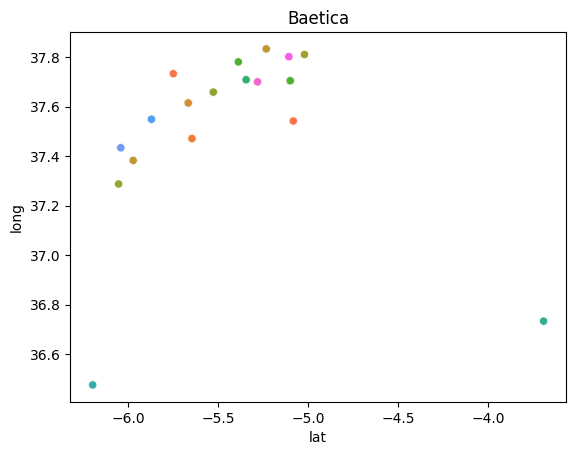

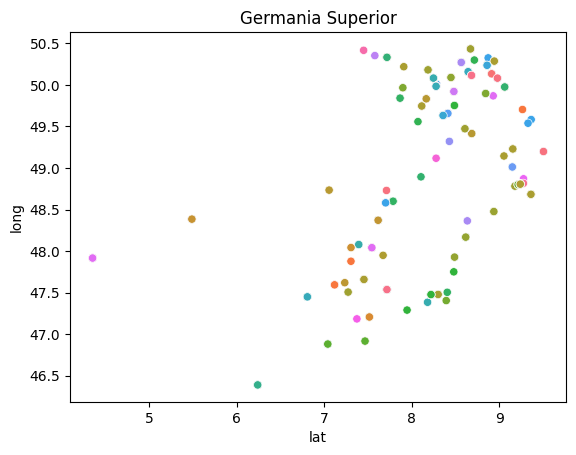

In [8]:
from matplotlib.cm import viridis
import seaborn as sns

#fix, axes = plt.subplots(len(data['province'].value_counts()), 1)
#i=0
#fig, ax = plt.subplots(data['province'].value_counts())
#for province, ax in zip(data['province'], axes.flatten()):
#for province in data['province']:
datasub = data[data['province']=='Baetica']
sns.scatterplot(x='lat', y='long', data=datasub, hue='code', legend=None).set_title('Baetica')
plt.show()
datasub = data[data['province']=='Germania Superior']
sns.scatterplot(x='lat', y='long', data=datasub, hue='code', legend=None).set_title('Germania Superior')
plt.show()
#plt.scatter(x='lat', y='long', data=datasub, color=colors2)
#plt.figure(figsize=(100, 10000))
#plt.show()

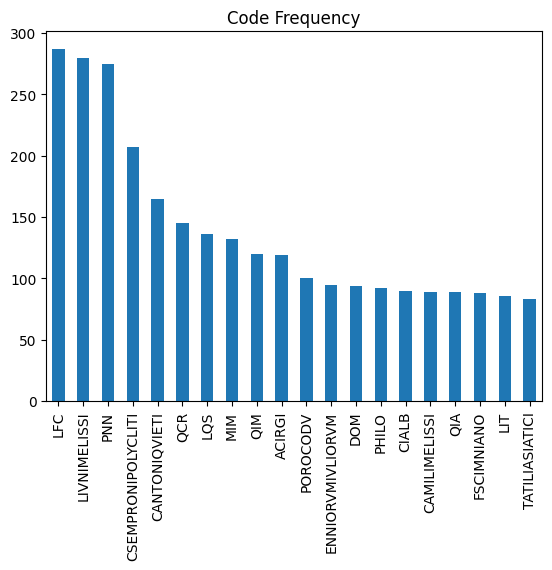

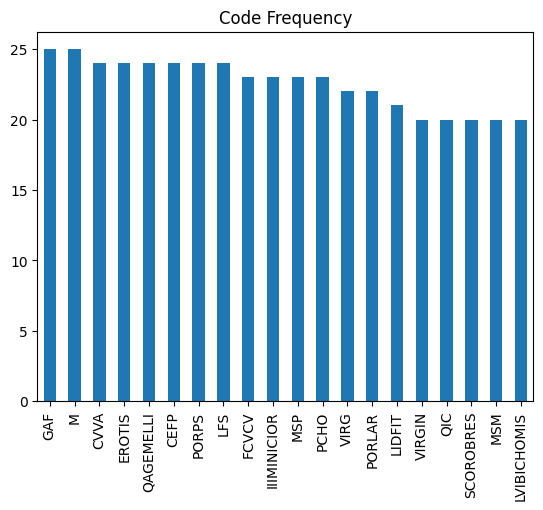

In [9]:
data['code'].value_counts()[0:20].plot(kind='bar', title='Code Frequency')
plt.show()
data['code'].value_counts()[-20:].plot(kind='bar', title='Code Frequency')
plt.show()

## Hyperdrive Configuration

TODO: Explain the model you are using and the reason for chosing the different hyperparameters, termination policy and config settings.

In [10]:
#x_df = data.drop(columns=['code'])
#x_df = pd.get_dummies(data, columns = ['site', 'province'])
#x_df.head(10)

In [11]:
# TODO: Create an early termination policy. This is not required if you are using Bayesian sampling.
early_termination_policy = BanditPolicy(evaluation_interval = 1, slack_factor = 0.15,delay_evaluation = 3)


if "training" not in os.listdir():
    os.mkdir("./training")

# Setup environment for your training run
sklearn_env = Environment.from_conda_specification(name='sklearn-env', file_path='conda_dependencies.yml')

#TODO: Create the different params that you will be using during training
param_sampling = RandomParameterSampling( {
        "--n": choice(range(50, 2500)),
        "--l": choice(range(1, 20)),
        "--d": choice(range(5, 500))
    }
)

#TODO: Create your estimator and hyperdrive config
estimator = ScriptRunConfig(source_directory='.',
                            script='train.py',
                            #arguments=['--arg1', arg1_val, '--arg2', arg2_val],
                            compute_target=cluster_name,
                            environment=sklearn_env)

# Create a HyperDriveConfig using the src object, hyperparameter sampler, and policy.
hyperdrive_config = HyperDriveConfig(run_config=estimator,
                    hyperparameter_sampling=param_sampling,
                    policy=early_termination_policy,
                    primary_metric_name= 'Accuracy',
                    primary_metric_goal= PrimaryMetricGoal.MAXIMIZE,
                    #max concurrent runs
                    max_total_runs=250,
                    max_concurrent_runs = 5,
                    max_duration_minutes = 120
                                    )





In [12]:
#TODO: Submit your experiment
run = experiment.submit(hyperdrive_config)


## Run Details

OPTIONAL: Write about the different models trained and their performance. Why do you think some models did better than others?

TODO: In the cell below, use the `RunDetails` widget to show the different experiments.

In [13]:
RunDetails(run).show()
run.wait_for_completion(show_output=True)

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

RunId: HD_b087aaf9-33ae-4ef3-9c6a-4fcb0bff0ee4
Web View: https://ml.azure.com/runs/HD_b087aaf9-33ae-4ef3-9c6a-4fcb0bff0ee4?wsid=/subscriptions/3d1a56d2-7c81-4118-9790-f85d1acf0c77/resourcegroups/aml-quickstarts-251949/workspaces/quick-starts-ws-251949&tid=660b3398-b80e-49d2-bc5b-ac1dc93b5254

Streaming azureml-logs/hyperdrive.txt

[2024-02-07T06:34:04.097773][GENERATOR][INFO]Trying to sample '5' jobs from the hyperparameter space
[2024-02-07T06:34:04.7048408Z][SCHEDULER][INFO]Scheduling job, id='HD_b087aaf9-33ae-4ef3-9c6a-4fcb0bff0ee4_0' 
[2024-02-07T06:34:04.9921046Z][SCHEDULER][INFO]Scheduling job, id='HD_b087aaf9-33ae-4ef3-9c6a-4fcb0bff0ee4_2' 
[2024-02-07T06:34:05.0389667Z][SCHEDULER][INFO]Successfully scheduled a job. Id='HD_b087aaf9-33ae-4ef3-9c6a-4fcb0bff0ee4_0' 
[2024-02-07T06:34:05.1019673Z][SCHEDULER][INFO]Scheduling job, id='HD_b087aaf9-33ae-4ef3-9c6a-4fcb0bff0ee4_3' 
[2024-02-07T06:34:05.1474544Z][SCHEDULER][INFO]Successfully scheduled a job. Id='HD_b087aaf9-33ae-4ef3-9c6a-

{'runId': 'HD_b087aaf9-33ae-4ef3-9c6a-4fcb0bff0ee4',
 'target': 'stampClusterHyper',
 'status': 'Completed',
 'startTimeUtc': '2024-02-07T06:34:02.853118Z',
 'endTimeUtc': '2024-02-07T08:35:14.967466Z',
 'services': {},
 'error': {'error': {'code': 'UserError',
   'message': 'Cancelling runs as max_duration has reached. Consider increasing max_duration. Timeout occured detected.',
   'messageParameters': {},
   'details': []},
  'time': '0001-01-01T00:00:00.000Z'},
 'properties': {'primary_metric_config': '{"name":"Accuracy","goal":"maximize"}',
  'resume_from': 'null',
  'runTemplate': 'HyperDrive',
  'azureml.runsource': 'hyperdrive',
  'platform': 'AML',
  'ContentSnapshotId': '18130013-87d5-461f-b0cb-9e3797b20ce8',
  'user_agent': 'python/3.8.5 (Linux-5.15.0-1040-azure-x86_64-with-glibc2.10) msrest/0.7.1 Hyperdrive.Service/1.0.0 Hyperdrive.SDK/core.1.51.0',
  'space_size': '23042250',
  'cancellation_reason': 'Cancelling experiment as max_duration has reached. Consider increasing m

## Best Model

TODO: In the cell below, get the best model from the hyperdrive experiments and display all the properties of the model.

In [23]:
#TODO: Save the best model
#get best model details
results = run.get_best_run_by_primary_metric()
print('The best run was: ')
print(results)
#print('The best run reported the following metrics: ')
#print(run.get_metrics())

The best run was: 
Run(Experiment: stamps_hyper,
Id: HD_b087aaf9-33ae-4ef3-9c6a-4fcb0bff0ee4_53,
Type: azureml.scriptrun,
Status: Completed)


In [27]:
#save model
model_name = 'stamps_hyper'
results.download_files("./outputs")

model = results.register_model(model_name=model_name, model_path='./outputs/model.joblib',
                               resource_configuration=ResourceConfiguration(cpu=1, memory_in_gb=1))

## Model Deployment

Remember you have to deploy only one of the two models you trained but you still need to register both the models. Perform the steps in the rest of this notebook only if you wish to deploy this model.

TODO: In the cell below, register the model, create an inference config and deploy the model as a web service.

In [28]:
#NB: Model deployment done in automl file

model.delete()
cpu_cluster.delete()

Current provisioning state of AmlCompute is "Deleting"



TODO: In the cell below, send a request to the web service you deployed to test it.

TODO: In the cell below, print the logs of the web service and delete the service

**Submission Checklist**
- I have registered the model.
- I have deployed the model with the best accuracy as a webservice.
- I have tested the webservice by sending a request to the model endpoint.
- I have deleted the webservice and shutdown all the computes that I have used.
- I have taken a screenshot showing the model endpoint as active.
- The project includes a file containing the environment details.

